## SetUp

In [1]:
#!pip install evaluate datasets transformers accelerate==1.9.0 wandb safetensors==0.4.3

In [ ]:
#!pip install evaluate datasets transformers accelerate==1.9.0 wandb safetensors==0.4.3

In [27]:
#!pip install -q datasets evaluate
#!pip install -q sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Timing performance sur example de model

In [14]:
import psutil

print("CPU cores:", psutil.cpu_count(logical=True))
print("RAM total:", round(psutil.virtual_memory().total / 1024**3, 2), "GB")

CPU cores: 8
RAM total: 30.99 GB


In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(2)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 1
Corrected: This sentence has bad grammar.
Inference time: 0.782 seconds


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(4)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 4
Corrected: This sentence has bad grammar.
Inference time: 0.415 seconds


## Dataset Transform

In [32]:
import pandas as pd
import boto3
bucket_name = 'sagemaker-studio-oxs6vznjds'
key = 'writing_gec/data/writing_corrections_2024-12-17_17_23_54.csv'
s3_client = boto3.client('s3', region_name='us-east-1')
obj = s3_client.get_object(Bucket=bucket_name, Key=key)
df = pd.read_csv(obj['Body'])
df = df[:5000]  # optional limit rows
print(df.shape)

(4761, 123)


In [33]:
df = df[["writing_id", "writing_content", "corrected_writing"]]
df.head()

,writing_id,writing_content,corrected_writing
0,f384a75d-cf08-4292-99e9-dd64ceae8088,"Ken,\n\nI appreciate the thorough summary of o...","Ken,\n\nI appreciate the thorough summary of o..."
1,296465d9-5d4f-402a-83dc-dd89c8766539,A client expressed dissatisfaction with a dela...,A client expressed dissatisfaction with the de...
2,cc271da5-1d25-4255-8f37-376b2591b2b4,I recently stayed at the Grandview Hotel in Pa...,I recently stayed at the Grandview Hotel in Pa...
3,58180ef5-c741-45c3-9720-1c69b30b4d4f,"Robotics is advancing more and more in Brazil,...","Robotics is advancing rapidly in Brazil, both ..."
4,a0a79b53-734d-465a-ada7-89fa5545525e,My favorite holiday is Christimas. Christimas ...,My favorite holiday is Christmas. Christmas is...


In [35]:
from datasets import Dataset, DatasetDict, load_dataset, concatenate_datasets

# Charger le dataset
ds_grammarly = load_dataset("dim/grammarly_coedit")

# Filtrer uniquement les exemples dont la task est 'gec'
ds_grammarly = ds_grammarly["train"].filter(lambda example: example["task"] == "gec")
ds_grammarly = ds_grammarly.remove_columns(["task"])

# Afficher le nombre d'exemples restants
print(ds_grammarly)
print(ds_grammarly[0])

df_hf = df.rename(columns={
    "writing_id": "_id",
    "writing_content": "src",
    "corrected_writing": "tgt"
})

ds_sft = Dataset.from_pandas(df_hf, preserve_index=False)

df1 = ds_sft.to_pandas()
df2 = ds_grammarly.to_pandas()

merged_df = pd.concat([df1, df2], ignore_index=True)

ds_merged = Dataset.from_pandas(merged_df, preserve_index=False)

split1 = ds_merged.train_test_split(test_size=0.3, seed=42)  # 70% train, 30% remaining
split2 = split1['test'].train_test_split(test_size=0.5, seed=42)  # 15% val, 15% test

ds_ft = DatasetDict({
    "train": split1['train'],
    "validation": split2['train'],
    "test": split2['test']
})

print(ds_ft)


Dataset({
    features: ['_id', 'src', 'tgt'],
    num_rows: 19823
})
{'_id': '0', 'src': 'Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.', 'tgt': 'For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'}
DatasetDict({
    train: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 17208
    })
    validation: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 3688
    })
    test: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 3688
    })
})


## SFT

In [36]:
MODELNAME = "t5-base"
PREFIX = "grammar: "

In [37]:
import torch
training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
training_device
import numpy as np

In [38]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained(MODELNAME)
model = T5ForConditionalGeneration.from_pretrained(MODELNAME)

In [40]:
def fix(example):
    # Remove the numeric prefix before colon
    string_list = example["src"].split(":")
    text = " ".join(string_list[1:]).strip()
    example["src"] = text
    return example

# Apply the cleaning function
ds_ft["train"] = ds_ft["train"].map(fix)

Map:   0%|          | 0/17208 [00:00<?, ? examples/s]

In [41]:
print(ds_ft["train"][0])

{'_id': '2902', 'src': 'In order for a car to be powered using CNG, there are certain modifications that needs to be done.', 'tgt': 'In order for a car to be powered using CNG, there are certain modifications that need to be done.'}


🔤 Max src length: 1636
🔤 Max tgt length: 8087
📊 95th percentile src length: 67.0
📊 95th percentile tgt length: 222.64999999999964


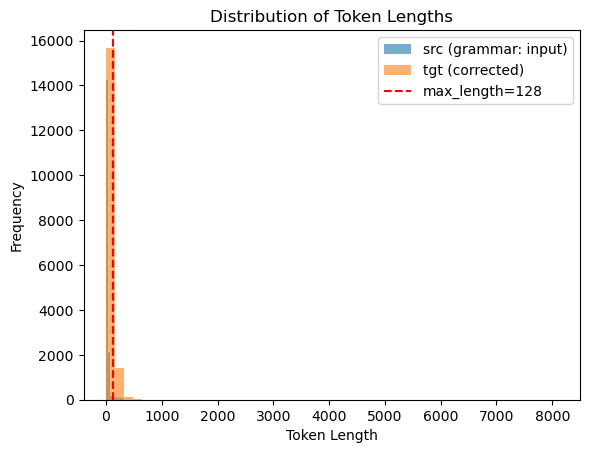

'\n🔤 Max src length: 199\n🔤 Max tgt length: 199\n📊 95th percentile src length: 52.0\n📊 95th percentile tgt length: 49.0\n'

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate lengths
src_lengths = [len(tokenizer.encode("grammar: " + x["src"])) for x in ds_ft["train"]]
tgt_lengths = [len(tokenizer.encode(x["tgt"])) for x in ds_ft["train"]]

# Stats
print(f"🔤 Max src length: {max(src_lengths)}")
print(f"🔤 Max tgt length: {max(tgt_lengths)}")
print(f"📊 95th percentile src length: {np.percentile(src_lengths, 95)}")
print(f"📊 95th percentile tgt length: {np.percentile(tgt_lengths, 95)}")

# Optional: Plot histograms
plt.hist(src_lengths, bins=50, alpha=0.6, label='src (grammar: input)')
plt.hist(tgt_lengths, bins=50, alpha=0.6, label='tgt (corrected)')
plt.axvline(128, color='red', linestyle='--', label='max_length=128')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Token Lengths')
plt.show()

"""
🔤 Max src length: 199
🔤 Max tgt length: 199
📊 95th percentile src length: 52.0
📊 95th percentile tgt length: 49.0
"""

In [29]:
dataset = ds_ft["train"].train_test_split(test_size=0.1, seed=42)
train_ds = ds_ft["train"]
val_ds = ds_ft["validation"]

In [30]:
def preprocess(example):
    input_text = PREFIX + example["src"]
    target_text = example["tgt"]
    model_inputs = tokenizer(input_text, truncation=True, padding="max_length", max_length=256)
    labels = tokenizer(target_text, truncation=True, padding="max_length", max_length=256)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(preprocess, batched=False)
tokenized_val = val_ds.map(preprocess, batched=False)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [31]:
import evaluate
import sacrebleu
import numpy as np

exact_match = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Exact match
    em = exact_match.compute(predictions=decoded_preds, references=decoded_labels)["exact_match"]

    # BLEU via sacrebleu
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    bleu_score = bleu.score

    return {"exact_match": em, "bleu": bleu_score}

In [32]:
import torch
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-grammar-corrector",
    do_eval=True,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,                             # The model to train
    args=training_args,                      # Training configurations
    train_dataset=tokenized_train,           # Tokenized training data
    eval_dataset=tokenized_val,              # Tokenized validation data
    tokenizer=tokenizer,                     # Tokenizer (for padding, decoding, etc.)
)

trainer.train()

"""
Epoch Training Loss Validation Loss
1 0.185000 0.165196
2 0.178100 0.161055
3 0.171300 0.160168
TrainOutput(global_step=27834, training_loss=0.1946344326956995, metrics={'train_runtime': 2212.8832, 'train_samples_per_second': 100.619, 'train_steps_per_second': 12.578, 'total_flos': 7533699872587776.0, 'train_loss': 0.1946344326956995, 'epoch': 3.0})
"""

/tmp/ipykernel_25414/1404983597.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss


"\nEpoch Training Loss Validation Loss\n1 0.185000 0.165196\n2 0.178100 0.161055\n3 0.171300 0.160168\nTrainOutput(global_step=27834, training_loss=0.1946344326956995, metrics={'train_runtime': 2212.8832, 'train_samples_per_second': 100.619, 'train_steps_per_second': 12.578, 'total_flos': 7533699872587776.0, 'train_loss': 0.1946344326956995, 'epoch': 3.0})\n"

In [33]:
model.save_pretrained("./t5-grammar-corrector")
tokenizer.save_pretrained("./t5-grammar-corrector")

"""
('./t5-grammar-corrector/tokenizer_config.json',
 './t5-grammar-corrector/special_tokens_map.json',
 './t5-grammar-corrector/spiece.model',
 './t5-grammar-corrector/added_tokens.json')
"""

"\n('./t5-grammar-corrector/tokenizer_config.json',\n './t5-grammar-corrector/special_tokens_map.json',\n './t5-grammar-corrector/spiece.model',\n './t5-grammar-corrector/added_tokens.json')\n"

In [34]:
eval_results = trainer.evaluate()
print("📊 Evaluation Results:", eval_results)

""" 
[1031/1031 00:25]
📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}
"""

📊 Evaluation Results: {'eval_loss': 0.34969887137413025, 'eval_runtime': 1.2431, 'eval_samples_per_second': 120.663, 'eval_steps_per_second': 15.284, 'epoch': 3.0}


" \n[1031/1031 00:25]\n📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}\n"

## Inference 

In [43]:
model = T5ForConditionalGeneration.from_pretrained("./t5-grammar-corrector/checkpoint-3500/")
tokenizer = T5Tokenizer.from_pretrained("./t5-grammar-corrector")

def correct_grammar(text: str):
    input_text = f"grammar: {text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    # Move to GPU if available
    input_ids = input_ids.to(model.device)

    output_ids = model.generate(input_ids, max_length=256, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

"""

❌ Original:  He go to school every day.
✅ Corrected: He goes to school every day.
"""

'\n\n❌ Original:  He go to school every day.\n✅ Corrected: He goes to school every day.\n'

In [53]:
# Try on a sample sentence
test_sentence = '''
"Dear Team,

I want to take a moment to express my deepest gratitude for all the hard work, dedication, and passion you bring to our organization every day. Each of you plays an integral role in our success, and I couldn't be prouder of the incredible strides we've made together.

This year has been filled with challenges, but your resilience and determination have turned those challenges into opportunities. Your creativity and teamwork continue to drive innovation, and it's because of your efforts that we’ve been able to achieve so much. Every project completed, every client satisfied, and every goal met is a testament to your commitment and talent.

As we look toward the future, I encourage you to stay motivated and keep believing in your abilities. Remember, no contribution is too small; together, we create something much greater than ourselves. If ever you feel overwhelmed, lean on your teammates, and don’t hesitate to share your ideas or concerns. We grow stronger by supporting each other.

Let’s continue to set new benchmarks and achieve even greater heights. Your work matters, your ideas matter, and most importantly, you matter. Thank you for being an essential part of this journey. Keep pushing forward—you are truly unstoppable!"
'''

corrected = correct_grammar(test_sentence)
print(f"\n❌ Original:  {test_sentence}")
print(f"✅ Corrected: {corrected}")



❌ Original:  
"Dear Team,

I want to take a moment to express my deepest gratitude for all the hard work, dedication, and passion you bring to our organization every day. Each of you plays an integral role in our success, and I couldn't be prouder of the incredible strides we've made together.

This year has been filled with challenges, but your resilience and determination have turned those challenges into opportunities. Your creativity and teamwork continue to drive innovation, and it's because of your efforts that we’ve been able to achieve so much. Every project completed, every client satisfied, and every goal met is a testament to your commitment and talent.

As we look toward the future, I encourage you to stay motivated and keep believing in your abilities. Remember, no contribution is too small; together, we create something much greater than ourselves. If ever you feel overwhelmed, lean on your teammates, and don’t hesitate to share your ideas or concerns. We grow stronger b